# Starter Notebook

Install and import required libraries

In [1]:
!pip uninstall transformers -y

Found existing installation: transformers 4.51.1
Uninstalling transformers-4.51.1:
  Successfully uninstalled transformers-4.51.1


In [2]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [3]:
import re
import json
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification, get_cosine_schedule_with_warmup
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

2025-04-15 17:35:53.114895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744738553.347645      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744738553.415901      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# import re
# import json
# import evaluate
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from torch.utils.data import DataLoader
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Load Tokenizer and Preprocess Data

In [5]:
base_model = 'roberta-base'

# ✅ 新增：加载 + 清洗 + 过滤文本
dataset = load_dataset('ag_news', split='train')
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

def clean_text(example):
    text = example["text"]
    text = re.sub(r'[^\w\s]', '', text)  # 去掉特殊字符
    text = re.sub(r'\s+', ' ', text).strip()
    example["text"] = text
    return example

def filter_fn(example):
    text_len = len(example['text'].split())
    return 5 < text_len < 200  # 丢掉太短或太长的样本

# 应用清洗和过滤
dataset = dataset.map(clean_text).filter(filter_fn)

tokenizer = RobertaTokenizer.from_pretrained(base_model)

# def preprocess(examples):
#     tokenized = tokenizer(examples['text'], truncation=True, padding=True)
#     return tokenized
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)
    
tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [6]:
# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [7]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [8]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [9]:
# ✅ 修改 LoRA 设置：更高秩、更强表达能力
peft_config = LoraConfig(
    r=8, 
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query", "key", "value", "dense"],  #记得检查参数数量
    task_type="SEQ_CLS"
)

In [10]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [11]:
# ✅ 新增：打印可训练参数，确保不超过 1M
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_trainable_params(peft_model):,}")

print("Trainable parameters:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)

Total trainable parameters: 1,933,060
Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.output.dense.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.output.dense.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.intermediate.dense.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.intermediate.dense.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.output.dense.lora_A.default.weight
base_model.model.roberta.enc

In [12]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 1,933,060 || all params: 126,594,056 || trainable%: 1.5270


## Training Setup

In [13]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ 修改：加入更多指标
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

In [14]:
# Setup Training args
output_dir = "results"
# ✅ 修改：优化器、调度器、保存策略
training_args = TrainingArguments(
    output_dir="results",
    eval_strategy='steps',
    eval_steps=250,
    save_strategy='steps',
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    learning_rate=5e-5,
    num_train_epochs=3,
    max_steps=3000,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    dataloader_num_workers=4,
    logging_steps=100,
    logging_dir="./logs",
    report_to="none",
    optim="adamw_torch",  # ✅ 替换原来的 sgd
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": True}
)
# training_args = TrainingArguments(
#     output_dir=output_dir,
#     report_to=None,
#     eval_strategy='steps',
#     logging_steps=100,
#     learning_rate=5e-6,
#     num_train_epochs=1,
#     max_steps=1200,
#     use_cpu=False,
#     dataloader_num_workers=4,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=64,
#     optim="sgd",
#     gradient_checkpointing=False,
#     gradient_checkpointing_kwargs={'use_reentrant':True}
# )

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [15]:
# peft_lora_finetuning_trainer = get_trainer(peft_model)

# # result = peft_lora_finetuning_trainer.train()
# peft_lora_finetuning_trainer = get_trainer(peft_model)

# result = peft_lora_finetuning_trainer.train()
trainer = get_trainer(peft_model)

from transformers import TrainerCallback

class LogHistoryCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            history.append(logs.copy())

history = []
trainer.add_callback(LogHistoryCallback())

# ========== 9. Train ==========
train_result = trainer.train()
trainer.save_model()

# ========== 10. Evaluate ==========
metrics = trainer.evaluate()
print("Final Evaluation Metrics:", metrics)
with open("results/final_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,1.322300,1.281996,0.817187,0.838796,0.817187,0.811007
500,1.149100,1.135209,0.876563,0.877018,0.876563,0.876624
750,1.015600,0.974788,0.864062,0.865545,0.864062,0.863178
1000,0.855300,0.839658,0.860938,0.861857,0.860938,0.859550
1250,0.782800,0.745416,0.860938,0.862359,0.860938,0.860083
1500,0.702900,0.678216,0.868750,0.869355,0.868750,0.868406
1750,0.650800,0.632185,0.871875,0.873114,0.871875,0.871621
2000,0.613700,0.596044,0.864062,0.865031,0.864062,0.863591
2250,0.603700,0.570514,0.870313,0.870655,0.870313,0.870184
2500,0.572200,0.553826,0.871875,0.871946,0.871875,0.871682


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/

Final Evaluation Metrics: {'eval_loss': 1.1352086067199707, 'eval_accuracy': 0.8765625, 'eval_precision': 0.8770179804227627, 'eval_recall': 0.8765625, 'eval_f1': 0.8766240383264279, 'eval_runtime': 3.0723, 'eval_samples_per_second': 208.315, 'eval_steps_per_second': 1.627, 'epoch': 0.8042895442359249}


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [16]:
# ✅ 修改：更简洁地显示预测
def classify(model, tokenizer, text):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    model.to(device)
    with torch.no_grad():
        output = model(**inputs)
        pred = output.logits.argmax(-1).item()
    print(f"\n[Prediction] Label: {id2label[pred]}, Text: {text[:80]}...")
    return id2label[pred]

In [17]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


[Prediction] Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ...

[Prediction] Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall ...


'Business'

### Run Inference on eval_dataset

In [18]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Returns:
        If labelled is True, returns a tuple (metrics_dict, predictions)
        If labelled is False, returns predictions only.
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_references = []

    # Load Hugging Face metrics
    if labelled:
        acc_metric = evaluate.load("accuracy")
        f1_metric = evaluate.load("f1")
        prec_metric = evaluate.load("precision")
        recall_metric = evaluate.load("recall")

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1).cpu()
        all_predictions.append(predictions)

        if labelled:
            references = batch["labels"].cpu()
            all_references.append(references)

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        all_references = torch.cat(all_references, dim=0)
        acc_metric.add_batch(predictions=all_predictions.numpy(), references=all_references.numpy())
        f1_metric.add_batch(predictions=all_predictions.numpy(), references=all_references.numpy())
        prec_metric.add_batch(predictions=all_predictions.numpy(), references=all_references.numpy())
        recall_metric.add_batch(predictions=all_predictions.numpy(), references=all_references.numpy())

        results = {
            "accuracy": acc_metric.compute()["accuracy"],
            "f1": f1_metric.compute(average="weighted")["f1"],
            "precision": prec_metric.compute(average="weighted")["precision"],
            "recall": recall_metric.compute(average="weighted")["recall"]
        }
        print("Evaluation Metrics:", results)
        return results, all_predictions
    else:
        return all_predictions

In [19]:
# # Check evaluation accuracy
# _, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

In [20]:
# ✅ 第 1 步：评估验证集
# 输出所有指标：accuracy, f1, precision, recall
eval_metrics, _ = evaluate_model(peft_model, eval_dataset, labelled=True, batch_size=8, data_collator=data_collator)


Evaluating: 100%|██████████| 80/80 [00:05<00:00, 14.96it/s]

Evaluation Metrics: {'accuracy': 0.8765625, 'f1': 0.8766240383264279, 'precision': 0.8770179804227627, 'recall': 0.8765625}


### Run Inference on unlabelled dataset

In [21]:
# #Load your unlabelled data
# unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
# test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
# unlabelled_dataset
# ✅ 第 2 步：加载未标注测试数据
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [22]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

Evaluating: 100%|██████████| 1000/1000 [01:07<00:00, 14.78it/s]

Inference complete. Predictions saved to inference_output.csv


In [23]:
# # Run inference and save predictions
# preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
# df_output = pd.DataFrame({
#     'ID': range(len(preds)),
#     'Label': preds.numpy()  # or preds.tolist()
# })
# df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
# print("Inference complete. Predictions saved to inference_output.csv")

# ✅ 第 3 步：模型推理并保存结果
preds = evaluate_model(peft_model, test_dataset, labelled=False, batch_size=8, data_collator=data_collator)

# ✅ 建议转换为 list 避免 numpy 版本兼容问题
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.tolist()  # ✅ 更推荐 than .numpy()
})

output_csv = os.path.join(output_dir, "inference_output.csv")
df_output.to_csv(output_csv, index=False)

print(f"Inference complete. Predictions saved to {output_csv}")

Evaluating: 100%|██████████| 1000/1000 [01:06<00:00, 14.96it/s]

Inference complete. Predictions saved to results/inference_output.csv


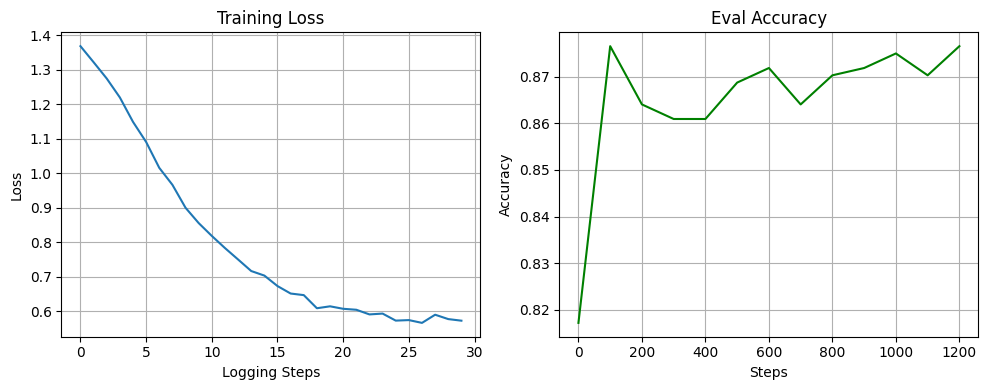

In [24]:
import matplotlib.pyplot as plt

train_loss = [log["loss"] for log in history if "loss" in log]
eval_acc = [log["eval_accuracy"] for log in history if "eval_accuracy" in log]
eval_steps = [i*100 for i in range(len(eval_acc))]  # 取 logging_steps=100 对应横坐标

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_acc, label='Eval Accuracy', color='green')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Eval Accuracy")
plt.grid(True)

plt.tight_layout()
plt.savefig("results/training_metrics_plot.png")
plt.show()
